[INFO] Data loaded successfully. Shape: (2200, 8)

--- Generating Visualizations ---
[INFO] Correlation plot saved to correlation_matrix.png


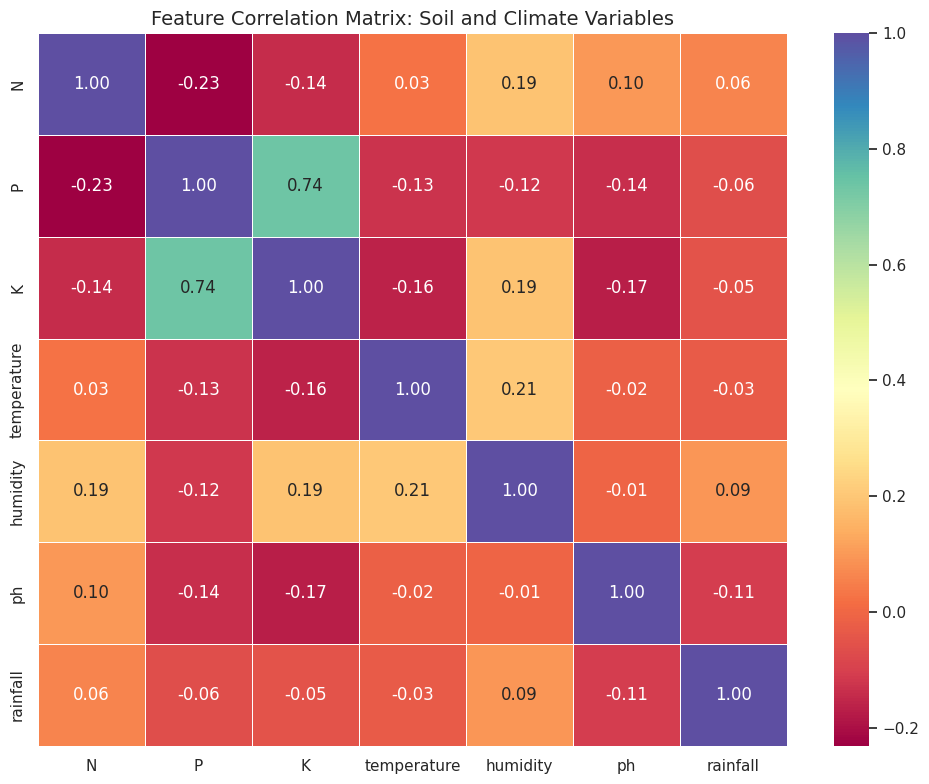

/tmp/ipython-input-706231835.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='N', data=df, order=sorted_idx, palette='viridis')


[INFO] Nitrogen distribution plot saved to nitrogen_dist.png


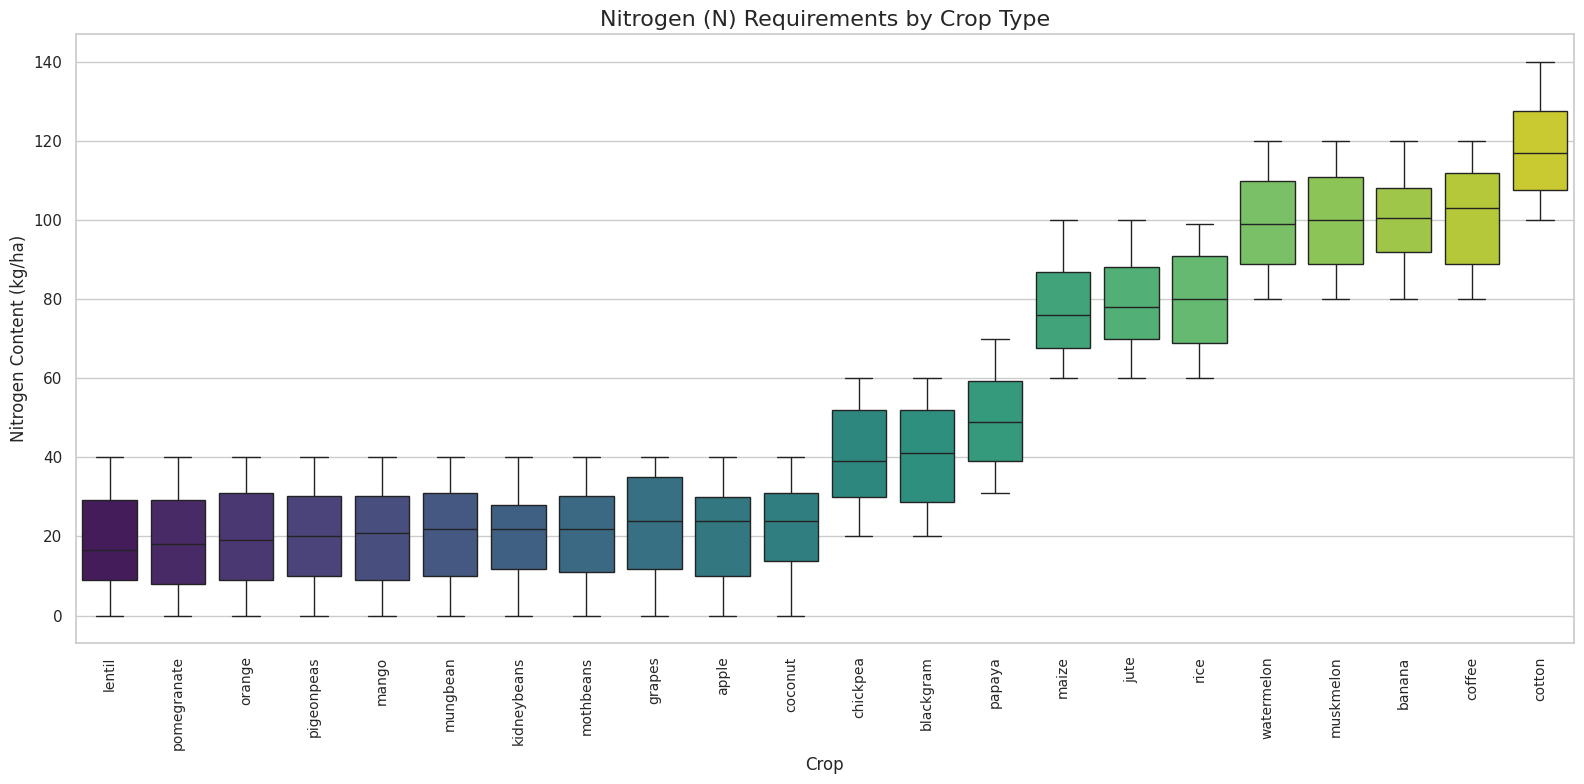


[INFO] Starting model training process...
[RESULT] Model Training Completed.
[RESULT] Validation Accuracy: 0.9932 (99.32%)


/tmp/ipython-input-706231835.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='magma')


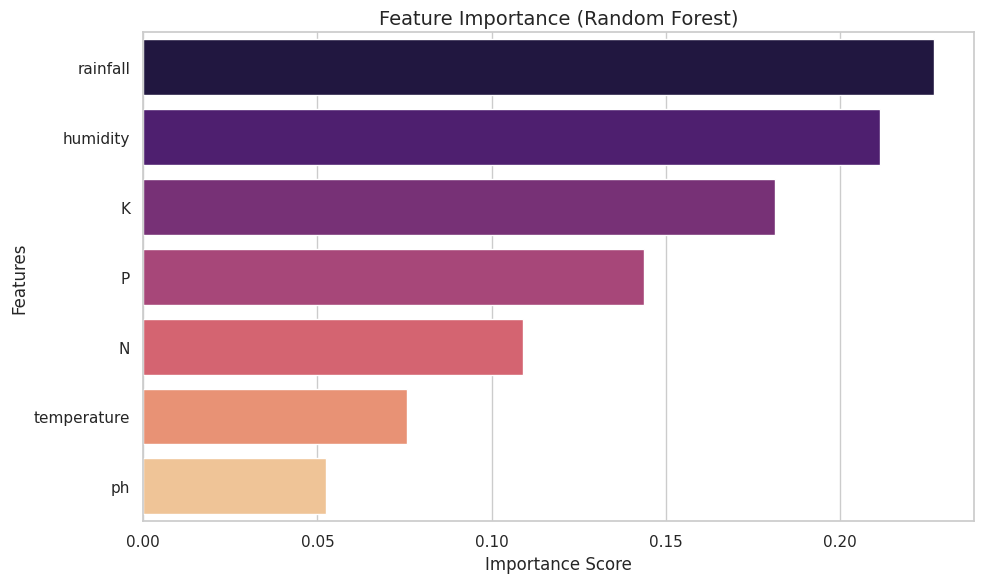


[INFO] Top 3 Most Important Features:
rainfall    0.227036
humidity    0.211279
K           0.181222
dtype: float64


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Optional
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# --- CONFIGURATION ---
DATASET_PATH = 'Crop_recommendation.csv'
RANDOM_SEED = 42
TEST_SIZE = 0.2
N_ESTIMATORS = 100
sns.set_theme(style="whitegrid")  # Set visual theme for all plots

def load_data(filepath: str) -> Optional[pd.DataFrame]:
    """
    Loads the dataset from a CSV file.

    Args:
        filepath (str): The path to the CSV file.

    Returns:
        pd.DataFrame: The loaded dataframe, or None if an error occurs.
    """
    try:
        df = pd.read_csv(filepath)
        print(f"[INFO] Data loaded successfully. Shape: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"[ERROR] File not found at: {filepath}. Please check the path.")
        return None
    except Exception as e:
        print(f"[ERROR] An unexpected error occurred: {e}")
        return None

def plot_correlation_matrix(df: pd.DataFrame, save_path: str = None):
    """
    Generates and displays a correlation heatmap for numerical features.

    Args:
        df (pd.DataFrame): The dataset containing numerical features.
        save_path (str, optional): Path to save the image.
    """
    plt.figure(figsize=(10, 8))

    # Select only numerical columns for correlation calculation
    numeric_df = df.select_dtypes(include=['float64', 'int64'])

    # Calculate correlation matrix
    corr_matrix = numeric_df.corr()

    # Plot heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='Spectral', fmt=".2f", linewidths=0.5)
    plt.title('Feature Correlation Matrix: Soil and Climate Variables', fontsize=14)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"[INFO] Correlation plot saved to {save_path}")
    plt.show()

def plot_nitrogen_distribution(df: pd.DataFrame, save_path: str = None):
    """
    Generates a boxplot showing Nitrogen distribution across different crop types.
    """
    plt.figure(figsize=(16, 8))

    # Sorting by median Nitrogen value for better visualization
    sorted_idx = df.groupby('label')['N'].median().sort_values().index

    sns.boxplot(x='label', y='N', data=df, order=sorted_idx, palette='viridis')
    plt.xticks(rotation=90, fontsize=10)
    plt.title('Nitrogen (N) Requirements by Crop Type', fontsize=16)
    plt.xlabel('Crop', fontsize=12)
    plt.ylabel('Nitrogen Content (kg/ha)', fontsize=12)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"[INFO] Nitrogen distribution plot saved to {save_path}")
    plt.show()

def train_model(df: pd.DataFrame) -> Tuple[RandomForestClassifier, float, pd.DataFrame, pd.Series]:
    """
    Preprocesses data, trains a Random Forest classifier, and evaluates it.

    Args:
        df (pd.DataFrame): The full dataset.

    Returns:
        Tuple containing:
            - Trained model
            - Accuracy score
            - X_test (for further evaluation)
            - y_test (ground truth)
    """
    print("\n[INFO] Starting model training process...")

    # Feature separation
    X = df.drop('label', axis=1)
    y = df['label']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED
    )

    # Initialize and train Classifier
    clf = RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=RANDOM_SEED)
    clf.fit(X_train, y_train)

    # Predictions
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"[RESULT] Model Training Completed.")
    print(f"[RESULT] Validation Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    return clf, accuracy, X_test, y_test

def plot_feature_importance(model: RandomForestClassifier, feature_names: pd.Index):
    """
    Visualizes which features were most important for the model's decision making.
    """
    importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances.values, y=importances.index, palette='magma')

    plt.title('Feature Importance (Random Forest)', fontsize=14)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\n[INFO] Top 3 Most Important Features:")
    print(importances.head(3))

# --- MAIN EXECUTION BLOCK ---
if __name__ == "__main__":
    # 1. Load Data
    df = load_data(DATASET_PATH)

    if df is not None:
        # 2. Exploratory Data Analysis (EDA)
        print("\n--- Generating Visualizations ---")
        plot_correlation_matrix(df, save_path='correlation_matrix.png')
        plot_nitrogen_distribution(df, save_path='nitrogen_dist.png')

        # 3. Machine Learning Pipeline
        trained_model, acc, X_test, y_test = train_model(df)

        # 4. Model Interpretability
        plot_feature_importance(trained_model, df.drop('label', axis=1).columns)

        # Optional: Detailed Classification Report
        # print("\n[INFO] Detailed Classification Report:")
        # print(classification_report(y_test, trained_model.predict(X_test)))